In [1]:
import numpy as np
import scipy
import torch
import torchvision
import csv
import pandas as pd
import imageio
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import os, sys
import glob
import json
import random
import ipdb
import base64
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

In [10]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(2,20, kernel_size=(5,5), stride=(1,1))
        nn.init.uniform_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(20)
        
        self.conv2 = nn.Conv2d(20,10, kernel_size=(5,5), stride=(1,1))
        nn.init.uniform_(self.conv2.weight)
        self.bn1 = nn.BatchNorm2d(10)
        
        self.fc1 = nn.Linear(1690,500)
        nn.init.uniform_(self.fc1.weight)
        self.bn3 = nn.BatchNorm1d(500)
        
        self.fc2 = nn.Linear(500,100)
        nn.init.uniform_(self.fc2.weight)
        self.bn4 = nn.BatchNorm1d(100)
        
        self.fc3 = nn.Linear(100,1)
        nn.init.uniform_(self.fc3.weight)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size = 2, stride=2, padding = 0,dilation=1,ceil_mode=False)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size = 2, stride=2, padding = 0,dilation=1,ceil_mode=False)
        x = F.relu(x)
        
        x = x.view(x.size(0), 1690)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = F.dropout(x, p=0.5)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = F.dropout(x, p=0.5)
        
        x = self.fc3(x)
        x = F.sigmoid(x)
        
        
        return x
        

In [11]:
def importdata(data, batch_size = 50):
    np.random.shuffle(data)
    batches = []
    
    re = data[:,1].astype(np.float64)
    re -= re.mean(0)
    re /= re.var(0)
    re = re.reshape(re.shape[0],1)
    re = re.astype(np.str)
    
    data = np.delete(data,1,1)
    data = np.insert(data,[1],re,axis=1)
    
    train_set = data[:15000,:]
    test_set = data[15000:,:]
    
    batch_number_train = int(train_set.shape[0]/batch_size)
    training_data = []
    
    for idx in range (0, batch_number_train):
        data = train_set[idx*batch_size:(idx + 1)*batch_size]
        training_data.append(data)
        
    training_data = np.array(training_data)
    
    batch_number_test = int(test_set.shape[0]/batch_size)
    testing_data = []
    
    for idx in range(0, batch_number_test):
        data = test_set[idx*batch_size:(idx+1)*batch_size,:]
        testing_data.append(data)
        
    testing_data = np.array(testing_data)
    
    return training_data, testing_data

In [12]:
def train(importtrain, optimizer, criterion, epoch, net, scope = 'cl'):
    net.train()
    train_loss_sum = 0
    for idx, batch in enumerate(importtrain):
        image_batch = []
        
        if scope == 'cl':
            target = (importtrain[idx,:,3]).reshape((len(importtrain[idx,:,3]),1))
            target = target.astype(float)
            target = torch.from_numpy(target).float()
            
        if scope == 'cd':
            target = (importtrain[idx,:,4]).reshape((len(importtrain[idx,:,3]),1))
            target = target.astype(float)
            target = torch.from_numpy(target).float()
            
        if scope == 'ld_ratio':
            target = (importtrain[idx,:,5]).reshape((len(importtrain[idx,:,3]),1))
            target = target.astype(float)
            target = torch.from_numpy(target).float()
            
        for k,row in enumerate(batch):
            img_name = importtrain[idx,k,0]+'_'+str(int(float(importtrain[idx,k,2])))+'.png'
            img = imageio.imread('./naca_imgs/'+img_name)
            re_array = np.full((64,64),importtrain[idx,k,1])
            img = np.dstack((re_array,img))
            image_batch.append(img)
            
        image_batch=np.array(image_batch,dtype = float)
        image_batch = np.transpose(image_batch,(0,3,1,2))
            
        image_batch = torch.from_numpy(image_batch).float()
        output = net(image_batch)
        loss = criterion(output,target)
            
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_sum += float(loss)
        if idx % 50 == 0:
            print('epoch ', epoch, 'no_batch ', idx, 'Train loss ', loss)
                
    train_loss = train_loss_sum/importtrain.shape[0]
    print("epoch ",epoch, "epoch_loss ", train_loss)
    return train_loss
    
    
def test(importtest, criterion,epoch,epochs,net,scope = 'cl'):
        net.eval()
        test_loss_sum = 0
        final_epoch = []
        
        for idx,batch in enumerate(importtest):
            image_batch =[]
            if epoch == epochs - 1:
                final_batch = batch
                
            if scope == 'cl':
                target = importtest[idx, :,3].reshape((len(importtest[idx,:,3]),1))
                target = target.astype(float)
                target = torch.from_numpy(target).float()
                
                
            if scope == 'cd':
                target = importtest[idx, :,4].reshape((len(importtest[idx,:,3]),1))
                target = target.astype(float)
                target = torch.from_numpy(target).float()
                
                
            if scope == 'ld_ratio':
                target = importtest[idx, :,5].reshape((len(importtest[idx,:,3]),1))
                target = target.astype(float)
                target = torch.from_numpy(target).float()
                
                
            for k,row in enumerate(batch):
                img_name = importtest[idx,k,0]+'_'+str(int(float(importtest[idx,k,2])))+'.png'
                img = imageio.imread('./naca_imgs/'+img_name)
                re_array = np.full((64,64),importtest[idx,k,1])
                img = np.dstack((re_array,img))
                image_batch.append(img)
                
                
            image_batch = np.array(image_batch,dtype = float)
            image_batch = np.transpose(image_batch,(0,3,1,2))
            image_batch = torch.from_numpy(image_batch).float()
            
            
            output = net(image_batch)
            
            loss = criterion(output,target)
            
            test_loss_sum += float(loss)
            
            if epoch == epochs-1:
                output = output.detach().numpy()
                final_batch = np.insert(final_batch,[5], output,axis = 1)
                final_epoch.append(final_batch)
                
            else:
                final_epoch = 5
                
            if idx%20 == 0:
                print('epoch ', epoch, 'no_batch ', idx, 'Test loss ', loss)
                
            test_loss = test_loss_sum/importtest.shape[0]
            print("epoch ",epoch, "epoch_loss ", test_loss)
            return test_loss, final_epoch
            
        
        
            
        
        
        

In [13]:
batch_size = 50
lr = 0.0001
epochs = 5

data = np.load("feature_data.npy")
training_data, testing_data = importdata(data)

cnn = ConvNet()
optimizer = torch.optim.Adam(cnn.parameters(), lr = lr)
criterion = nn.MSELoss()

train_loss_list = []
test_loss_list = []
epoch_list = []

for epoch in range(epochs):
    train_loss  = train(training_data, optimizer,criterion,epoch,cnn,scope = 'cl')
    test_loss,output_data = test(testing_data,criterion,epoch,epochs,cnn,scope = 'cl')
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
    epoch_list.append(epoch)

C:\Users\aplus\AppData\Local\Temp\ipykernel_28680\3275313959.py:9: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  re = re.astype(np.str)
D:\Anaconda\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch  0 no_batch  0 Train loss  tensor(1.6959, grad_fn=<MseLossBackward0>)
epoch  0 no_batch  50 Train loss  tensor(1.6408, grad_fn=<MseLossBackward0>)
epoch  0 no_batch  100 Train loss  tensor(2.1361, grad_fn=<MseLossBackward0>)
epoch  0 no_batch  150 Train loss  tensor(1.5446, grad_fn=<MseLossBackward0>)
epoch  0 no_batch  200 Train loss  tensor(1.6300, grad_fn=<MseLossBackward0>)
epoch  0 no_batch  250 Train loss  tensor(1.3798, grad_fn=<MseLossBackward0>)
epoch  0 epoch_loss  1.582734574874242
epoch  0 no_batch  0 Test loss  tensor(1.5342, grad_fn=<MseLossBackward0>)
epoch  0 epoch_loss  0.017046484682295058
epoch  1 no_batch  0 Train loss  tensor(1.6959, grad_fn=<MseLossBackward0>)
epoch  1 no_batch  50 Train loss  tensor(1.6408, grad_fn=<MseLossBackward0>)
epoch  1 no_batch  100 Train loss  tensor(2.1361, grad_fn=<MseLossBackward0>)
epoch  1 no_batch  150 Train loss  tensor(1.5446, grad_fn=<MseLossBackward0>)
epoch  1 no_batch  200 Train loss  tensor(1.6300, grad_fn=<MseLossBack

In [18]:
output_data.shape

(1, 50, 7)

In [19]:
output_data=np.array(output_data)
np.save("predictions",output_data)
output_data=output_data.reshape((50,7))
output_data=output_data.astype(str)
np.savetxt("NACA_predictions.csv", output_data, delimiter=",", fmt='%s')

In [20]:
np.save("train loss ",train_loss_list)
np.save("test loss ",test_loss_list)

In [23]:
test_loss

0.017046484682295058

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

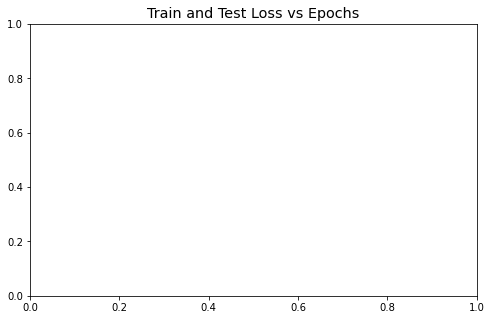

In [49]:
epochs= np.linspace(1,100,100)
plt.figure(figsize=(8,5))
plt.title("Train and Test Loss vs Epochs",fontsize='x-large')
plt.plot(epochs,train_loss,label='Train')
plt.plot(epochs,test_loss,label='Test')
plt.xlabel("Epochs",fontsize='x-large')
plt.ylabel("Loss",fontsize='x-large')
plt.legend(fontsize='x-large')
plt.savefig('./CNN_loss_plot.png',dpi=288)